In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
import shapely.geometry
import sys
import shapely.ops as so

In [2]:
def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [3]:
"""Initial Setup"""
# Position
x0 = 0
xf = 40
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
K = 10000
iter_max = 1000
tMax = 20
vmax = 2
max_time = 5

def generate_map():
    # Obstacle Setting
    num_obs = rn.randint(8, 10)
    # num_obs = 8
    xobs_thickness = []
    for i in range(num_obs):
        xobs_thickness.append(rn.uniform(0.5,2))
    xobs = []
    while len(xobs) < num_obs:
        for i in range(num_obs):
            if len(xobs) == num_obs:
                break
            temp = rn.uniform(x0+1, xf-3)
            xobs_i = [temp, temp+xobs_thickness[i]]
            if len(xobs) == 0:
                xobs.append(xobs_i)
            else:
                overlap_check = []
                for ii in range(len(xobs)):
                    if np.abs(xobs_i[0] - xobs[ii][0]) >= 2:
                        overlap_check.append(1)
                    else:
                        overlap_check.append(0)
                if sum(overlap_check) == len(xobs):
                    xobs.append(xobs_i)
    # [start, close, open]
    obs_vec = []
    min_period = 5
    max_period = 20
    for i in range(num_obs):
        random_period = rn.uniform(min_period, max_period)
        thickness_i = xobs_thickness[i]
        temp = rn.uniform((thickness_i/vmax)+2, random_period-2)
        obs_vec.append([0, temp, random_period-temp])
    return num_obs, xobs, obs_vec

In [4]:
num_obs, xobs, obs_vec = generate_map()
print(num_obs)
print(xobs)
print(obs_vec)

10
[[9.620648938651168, 11.328059571065593], [20.48650095222088, 21.11586277689147], [4.414370593700667, 5.522203912111661], [17.796081033081506, 18.717398790419114], [26.012786548908146, 26.926070565067498], [23.905240183358856, 25.152383658518474], [36.59474614347493, 37.190822357056426], [12.980789359377797, 13.610151184048387], [33.380838464312355, 34.48867178272335], [29.940968463518978, 30.94121218319402]]
[[0, 11.95325300071056, 4.094511357096188], [0, 3.2394638927233483, 2.1598767553970344], [0, 6.431445283563098, 4.938306366623349], [0, 7.837890742308019, 9.232932187393299], [0, 2.770651970821996, 2.8847406157961446], [0, 3.629833811209413, 4.954425001931322], [0, 6.3484996416819826, 4.349970457341396], [0, 3.86934851507021, 9.133630452127203], [0, 5.097915608066998, 4.102406848203302], [0, 6.55748159407993, 3.411848459739274]]


10
10
10


Text(0, 0.5, 't')

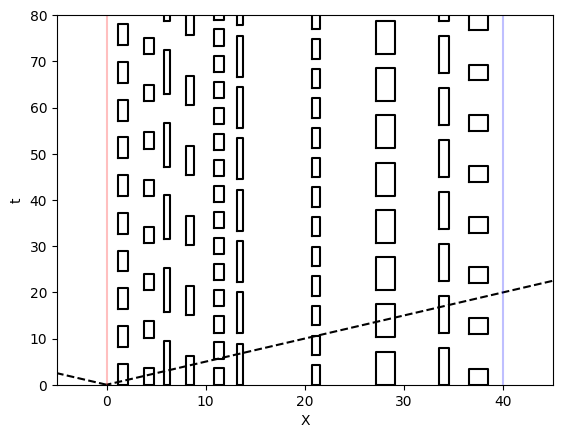

In [5]:
# TODO:
# Find minimum gap between obstacle given thickness and vmax

num_obs, xobs, obs_vec = generate_map()
print(num_obs)
print(len(xobs))
print(len(obs_vec))

fig = plt.figure()
ax = fig.subplots()
t_temp = 80
# Obstacle
tspace = np.linspace(0, t_temp, 100)
for i in range(num_obs):
    obs_number = int((t_temp//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

point1 = [x0, 0]
point2 = [xf, t_temp]
point3 = [-vmax/2*(t_temp - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(t_temp - 1/vmax*(xf+x0)))+x0/vmax]
point4 = [vmax/2*(t_temp + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(t_temp + 1/vmax*(xf+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Initial/Final
plt.plot([x0, x0], [0, t_temp+5], 'r-', alpha=0.25)
plt.plot([xf, xf], [0, t_temp+5], 'b-', alpha=0.25)

# Plot Limits
plt.xlim(x0-5, xf+5)
plt.ylim(0, t_temp)
plt.xlabel('X')
plt.ylabel('t')

In [6]:
def distance(a, b):
    return b - a

In [7]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [8]:
# def random_sample():
#     # Deprecated
#     trand = rn.uniform(1e-1, tMax)
#     check = rn.uniform(0, 1)
    
#     if check >= 0 and check < 0.9:
#         xrand = rn.uniform(trand*(-vmax)+x0, trand*vmax+x0)
#     elif check >= 0.9:
#         xrand = xf
#         trand = xf
#     qrand = [xrand, trand]
#     return qrand

def random_sample():
    n = 1
    trand = rn.uniform(0, 1e3)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [-vmax/2*(trand - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(trand - 1/vmax*(xf+x0)))+x0/vmax]
        point3 = [vmax/2*(trand + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(trand + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
    # print('xrand, trand: ', xrand, trand)
    return [xrand, trand]

In [9]:
def check_route(q1, q2, t1):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((t1//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [10]:
def reachable(q0, q1):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    # print('dx, dt: ', dx, dt)
    if dt > 0 and np.abs(dx/dt) <= vmax:
        return True
    else:
        return False

In [11]:
def find_neighbor(qrand, V):
    # Find neighbor
    dist_vec = []
    for vi in V:
        if reachable(vi, qrand):
            dist_vec.append(np.sqrt((vi[0]-qrand[0])**2 + (vi[1]-qrand[1])**2))
        else:
            dist_vec.append(1e100)
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [12]:
def extend(qclosest, q1, max_time):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    max_distance = max_time

    if np.abs(dx) <= max_distance and np.abs(dt) <= max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2 + dt**2)
        dxnorm = dx/norm*max_distance
        dtnorm = dt/norm*max_distance
        qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

In [13]:
def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec

In [14]:
"""Standard RRT"""
def standard_RRT(compTimeLimit):
    total_path_time = 0
    total_path_distance = 0
    k = 0
    V_RRT = []
    V_RRT.append([x0, 0])
    T_RRT = []
    T_RRT.append(0)
    E_RRT = []

    path_RRT = None
    # while k < K:
    start = time.time()
    while 1:
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRT)
            if qclosest is not None:
                qnew = extend(qclosest, qrand, max_time)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0 and check_route(qclosest, qnew, qrand[1]):
                    break

        # Add V, E
        k += 1
        V_RRT.append(qnew)
        E_RRT.append([qclosest, qnew])
        T_RRT.append(qnew[1])

        # Check continue
        if np.abs(distance(xf, qnew[0])) <= 1:
            dist_to_fin = distance(xf, qnew[0])
            qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRT.append(qfin)
            E_RRT.append([qnew, qfin])
            path_RRT = find_path(xf, E_RRT)
            for fpv in range(len(path_RRT)-1):
                total_path_time += (path_RRT[fpv+1][1]-path_RRT[fpv][1])
                total_path_distance += np.abs(path_RRT[fpv+1][0]-path_RRT[fpv][0])
            break

        if time.time()-start > compTimeLimit:
            break
    end = time.time()

    if path_RRT is not None:
        return True, end-start, total_path_distance, total_path_time, 1, path_RRT, V_RRT, E_RRT, T_RRT
    else:
        return False, end-start, total_path_distance, total_path_time, 0, path_RRT, V_RRT, E_RRT, T_RRT

RRT
13.734987258911133


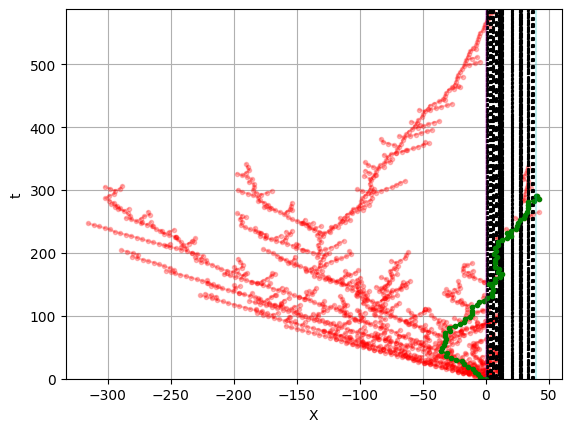

In [15]:
start = time.time()
print('RRT')
pathFound, time_RRT, RRTstar_total_distance, RRTstar_total_time, success_RRT, path_RRT, V_RRT, E_RRT, T_RRT = standard_RRT(20)
print(time.time()-start)

fig = plt.figure()
ax = fig.subplots()
tf = V_RRT[-1][1]
# RRT
for rrtv in V_RRT:
    plt.plot(rrtv[0], rrtv[1], 'r.', alpha=0.25)
for rrte in E_RRT:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

Path
if path_RRT is not None:
    for pathi in path_RRT:
        plt.plot(pathi[0], pathi[1], '.g')
    for pathi in range(len(path_RRT)-1):
        plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-g')

# Initial/Final
plt.plot([x0, x0], [0, max(T_RRT)+5], 'm-', alpha=0.25)
plt.plot([xf, xf], [0, max(T_RRT)+5], 'c-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf+1)
plt.ylim(0, max(T_RRT)+5)
plt.xlabel('X')
plt.ylabel('t')
plt.grid()

In [16]:
# path_found, compTime, RRT_total_distance, RRT_total_time, success, path_RRT, V_RRT, E_RRT, T_RRT = standard_RRT(compTimeLimit=0.5)
# print('Path Found?: ', path_found)
# print('Computation Time: ', compTime)
# print('RRT_total_distance: ', RRT_total_distance)

In [17]:
def neighbors(prox, q0, V_RRTstar):
    output = []
    for v in V_RRTstar:
        if 0 <= q0[0]-v[0] <= prox[0] and 0 <= q0[1]-v[1] <= prox[1] and reachable(q0, v):
            output.append(v)
    return output

In [18]:
"""Stardard RRT*"""
def standard_RRTstar(compTimeLimit):
    K = 10000
    total_path_time = 0
    total_path_distance = 0
    success_RRTstar = 0

    # print('iter: ', iter)
    k = 0
    V_RRTstar = []
    V_RRTstar.append([x0, 0])
    T_RRTstar = []
    T_RRTstar.append(0)
    E_RRTstar = []
    path_RRTstar = None
    start = time.time()
    while 1:
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRTstar)
            if qclosest is not None:
                qnew = extend(qclosest, qrand, max_time)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0:
                    if check_route(qclosest, qnew, qrand[1]):
                        break
        # Add V, E
        k += 1
        V_RRTstar.append(qnew)
        E_RRTstar.append([qclosest, qnew])
        T_RRTstar.append(qnew[1])

        # Rewiring
        if k > 1:
            qmin = qclosest
            cost_old = np.sqrt((qclosest[0]-qnew[0])**2+(qclosest[1]-qnew[1])**2)
            neighbor_vector = neighbors(prox, qnew, V_RRTstar)
            if len(neighbor_vector) > 0:
                for v in neighbor_vector:
                    if cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2) < np.sqrt((qclosest[0]-v[0])**2+(qclosest[1]-v[1])**2) and check_route(v, qnew):
                        cost_old = cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2)
                        qmin = v
                E_RRTstar.append([qnew, qmin])

        # Check continue
        if np.abs(distance(xf, V_RRTstar[-1][0])) <= 1:
            dist_to_fin = distance(xf, qnew[0])
            qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRTstar.append(qfin)
            E_RRTstar.append([qnew, qfin])
            success_RRTstar += 1
            path_RRTstar = find_path(xf, E_RRTstar)
            for fpv in range(len(path_RRTstar)-1):
                total_path_time += path_RRTstar[fpv+1][1]-path_RRTstar[fpv][1]
                total_path_distance += path_RRTstar[fpv+1][0]-path_RRTstar[fpv][0]
            break
        if time.time()-start > compTimeLimit:
            break
    end = time.time()

    if path_RRTstar is not None:
        return True, end-start, np.abs(total_path_distance), np.abs(total_path_time), 1, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar
    else:
        return False, end-start, total_path_distance, total_path_time, 0, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar

In [19]:
# pathFound, time, a, b, c, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar = standard_RRTstar(10)

# fig = plt.figure()
# ax = fig.subplots()
# tf = V_RRTstar[-1][1]
# # RRTstar
# for rrtv in V_RRTstar:
#     plt.plot(rrtv[0], rrtv[1], 'r.', alpha=0.25)
# for rrte in E_RRTstar:
#     plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)

# # Obstacle
# tspace = np.linspace(0, tf+5, 100)
# for i in range(len(xobs)):
#     obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
#     for j in range(obs_number):
#         this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
#         plt.plot(*this_obstacle.exterior.xy, 'k')

# # Path
# if path_RRTstar is not None:
#     for pathi in path_RRTstar:
#         plt.plot(pathi[0], pathi[1], '.g')
#     for pathi in range(len(path_RRTstar)-1):
#         plt.plot([path_RRTstar[pathi][0], path_RRTstar[pathi+1][0]], [path_RRTstar[pathi][1], path_RRTstar[pathi+1][1]], '-g')


# # Initial/Final
# plt.plot([x0, x0], [0, max(T_RRTstar)+5], 'r-', alpha=0.25)
# plt.plot([xf, xf], [0, max(T_RRTstar)+5], 'b-', alpha=0.25)

# # Plot Limits
# #plt.xlim(xf[0]-1, xf+1)
# plt.ylim(0, 200+5)
# plt.xlabel('X')
# plt.ylabel('t')
# # plt.grid()

In [20]:
# path_found, compTime, RRTstar_total_distance, RRTstar_total_time, success, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar = standard_RRTstar(compTimeLimit=1)
# print('Path Found?: ', path_found)
# print('Computation Time: ', compTime)
# print('RRT_total_distance: ', RRTstar_total_distance)

In [21]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [22]:
def reachable_RRTC(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    
    if dx == 0:
        return True
    else:
        if forward and np.abs(dx/dt) <= vmax and dt > 0:
            return True
        elif not forward and np.abs(dx/dt) <= vmax and dt < 0:
            return True
        return False

In [23]:
def random_sample_RRTC(tf, n, k):
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal and n == 1:
        # IF not, sample goal
        if np.mod(k, 2) == 0: # Start from bottom tree (x0)
            xrand = xf
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = x0
            trand = 0
    elif not sample_goal or n >= 1:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        if n == 1:
            xrand = rand_points[0][0]
            trand = rand_points[0][1]
            return [xrand, trand]
        else:
            return rand_points
    return [xrand, trand]

In [24]:
# def extend(qclosest, q1, max_time):
#     dx = q1[0]-qclosest[0]
#     dt = q1[1]-qclosest[1]
#     max_distance = max_time

#     if np.abs(dx) <= max_distance and np.abs(dt) <= max_time:
#         qnew = q1
#     else:
#         norm = np.sqrt(dx**2 + dt**2)
#         dxnorm = dx/norm*max_distance
#         dtnorm = dt/norm*max_distance
#         qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
#     return qnew

In [25]:
def find_neighbor_RRTC(qrand, V, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,2) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, forward):
            dist_vec.append(distance(V[i][0], qrand[0]))
        else:
            dist_vec.append(1e100)

    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [26]:
def check_route_test(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [27]:
def find_path_test(vi, vf, V, E, trigger):
    # trigger:
    # 0 -> a
    # 1 -> b
    path_vec = []
    path_vec.append(vf)
    curr = vf
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                if trigger == 0:
                    curr = E[ei][0]
                else:
                    curr = E[ei][0]
                path_vec.append(curr)
                break
        kek += 1

        if trigger == 0:
            if curr[0] == vi[0] and curr[1] == vi[1]:
                return path_vec
        elif trigger == 1:
            if np.abs(curr[0]-vi[0]) <= 0.1:
                return path_vec
            

In [28]:
# Standard ST-RRT-Connect
def standard_RRTC(compTimeLimit):
    K = 2500
    total_path_time = 0
    total_path_distance = 0
    tf = xf/vmax + 50
    start = time.time()
    for kek in range(4):
        final_path = None
        # print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCb = []
        V_RRTCb.append([xf, tf])

        V_RRTCa_raw = []
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        while 1:
        # while k < K:
            # print('k: ', k)
            while 1:
                # Sample
                qrand = random_sample_RRTC(tf, 1, k)
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
               
                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)
                        
                    # Validate
                    check_vec = validate(qnew)
                    if np.sum(check_vec) == 0:
                        if check_route_test(qclosest, qnew, tf):
                            break
                
            # Add V, E
            if np.mod(k, 2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
                V_RRTCa_raw.append(qrand)
            else:
                V_RRTCb.append(qnew)
                E_RRTCb.append([qclosest, qnew])
                T_RRTCb.append(qnew[1])
                V_RRTCb_raw.append(qrand)

            # Check continue
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tf) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[-1], forward=False):
                        if check_route_test(vi, V_RRTCb[-1], tf) and reachable_RRTC(vi, V_RRTCb[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb[-1]]
                            path_check = True
                            break
            k += 1

            if path_check:
                E_RRTC = E_RRTCa + E_RRTCb
                E_RRTC.append(connect_edge)
                patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
                pathb = find_path_test([xf, tf], E_RRTC[-1][1], V_RRTCb, E_RRTCb, 1)
                final_path = list(reversed(patha)) + pathb                
                for fpv in range(len(final_path)-1):
                    total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                    total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
                break
            if time.time()-start > compTimeLimit:
                break
        if path_check:
            break
        tf += 20
    end = time.time()
    
    if path_check:
        return True, end-start, total_path_distance, total_path_time, 1, final_path, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb


In [29]:
# path_found, compTime, RRTC_total_distance, RRTC_total_time, success, path_RRTC, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb = standard_RRTC(compTimeLimit=10)
# print('Path Found?: ', path_found)
# print('Computation Time: ', compTime)
# print('RRT_total_distance: ', RRTC_total_distance)

In [30]:
# fig = plt.figure(figsize=(10,6))
# ax = fig.subplots()
# # RRTConnect


# for rrtv in V_RRTCa:
#    plt.plot(rrtv[0], rrtv[1], 'r*', alpha=0.25)
# for rrtv in V_RRTCb:
#    plt.plot(rrtv[0], rrtv[1], 'b.', alpha=1)
# for rrte in E_RRTCa:
#     plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.5)
# for rrte in E_RRTCb:
#     plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=1)
# if path_found:
#     for pathi in path_RRTC:
#         plt.plot(pathi[0], pathi[1], 'gx')
#     for ii in range(len(path_RRTC)-1):
#         plt.plot([path_RRTC[ii][0], path_RRTC[ii+1][0]], [path_RRTC[ii][1], path_RRTC[ii+1][1]], '-g')




# # Obstacle
# if path_found:
#     tarbitrary = path_RRTC[-1][1]
# else:
#     tarbitrary = 100
# tspace = np.linspace(0, tarbitrary+5, 100)
# for i in range(len(xobs)):
#     obs_number = int((tarbitrary+5//np.sum(obs_vec[i]))+1)
#     for j in range(obs_number):
#         this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
#         plt.plot(*this_obstacle.exterior.xy, 'k')

# # Initial/Final
# plt.plot([x0, x0], [0, tarbitrary+5], 'r-', alpha=0.25)
# plt.plot(xf, tarbitrary, 'xb', alpha=0.5)
# plt.plot([xf, xf], [0, tarbitrary+5], 'b-', alpha=0.25)




# # ST-Bound
# point1 = [x0, 0]
# point2 = [xf, tarbitrary]
# point3 = [-vmax/2*(tarbitrary - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tarbitrary - 1/vmax*(xf+x0)))+x0/vmax]
# point4 = [vmax/2*(tarbitrary + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tarbitrary + 1/vmax*(xf+x0))) - x0/vmax]
# plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
# plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
# plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
# plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# # for rrtv in V_RRTCa_raw:
# #    plt.plot(rrtv[0], rrtv[1], 'm*', alpha=1)
# # for rrtv in V_RRTCb_raw:
# #    plt.plot(rrtv[0], rrtv[1], 'c*', alpha=1)

# # Plot Limits
# ax.axis('square')
# plt.xlim(x0-10, xf+10)
# plt.ylim(-5, tarbitrary+5)
# plt.xlabel('X')
# plt.ylabel('t')

In [31]:
"""ST-RRT with Time Shadow"""
def isInside(A, B, C, x, y):
    # Decomposition
    x1 = A[0]
    y1 = A[1]
    x2 = B[0]
    y2 = B[1]
    x3 = C[0]
    y3 = C[1]

    c1 = (x2-x1)*(y-y1)-(y2-y1)*(x-x1)
    c2 = (x3-x2)*(y-y2)-(y3-y2)*(x-x2)
    c3 = (x1-x3)*(y-y3)-(y1-y3)*(x-x3)
    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        # In Triangle
        return True
    else:
        # Not in Triangle
        return False
    
def obstacle_check_timeshadow(q2, obs_pos, obs_t, forward= True):
    trand = q2[1]
    temp = trand - obs_t[0]
    tempt = np.mod(temp, obs_t[1]+obs_t[2])

    if tempt >= obs_t[1] and tempt <= (obs_t[1]+obs_t[2]):
        if forward:
            # Not Caught
            X1 = [obs_pos[0], obs_t[1]+obs_t[2]]
            X2 = [obs_pos[1], obs_t[1]+obs_t[2]]
            X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[0]+(obs_pos[1]-obs_pos[0])/2)/vmax + (X2[1]-X2[0]/vmax)]
        else:
            X1 = [obs_pos[0], obs_t[1]]
            X2 = [obs_pos[1], obs_t[1]]
            X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[0]+(obs_pos[1]-obs_pos[0])/2)/vmax + (X1[1]-X1[0]/vmax)]

        if isInside(X1, X2, X3, q2[0], tempt):
            # Caught
            return False
        else:
            return True
    else:
        # Caught
        return False 
    
def validate_timeshadow(q2, k):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if np.mod(k,2) == 0:
                if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i], True):
                    check_vec.append(0)
                else:
                    check_vec.append(1)
            else:
                if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i], False):
                    check_vec.append(0)
                else:
                    check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle_timeshadow(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]
    timeblock = shapely.geometry.Polygon([point1, point2, point3, point4])

    # Downward Triangle
    X1 = [pos_obs[0], time_obs[0]+time_obs[1]+time_obs[2]+time_translate]
    X2 = [pos_obs[1], time_obs[0]+time_obs[1]+time_obs[2]+time_translate]
    X3 = [pos_obs[0]+(pos_obs[1]-pos_obs[0])/2, (pos_obs[0]+(pos_obs[1]-pos_obs[0])/2)/vmax + (X2[1]-X2[0]/vmax)]
    downTriangle = shapely.geometry.Polygon([X1, X2, X3])

    # Upward Triangle
    X4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]
    X5 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    X6 = [pos_obs[0]+(pos_obs[1]-pos_obs[0])/2, (pos_obs[0]+(pos_obs[1]-pos_obs[0])/2)/vmax + (X4[1]-X4[0]/vmax)]
    upperTriangle = shapely.geometry.Polygon([X4, X5, X6])

    return so.unary_union([timeblock, downTriangle, upperTriangle])

def check_route_test_timeshadow(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle_timeshadow(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [32]:
# Standard ST-RRT-Connect with Timeshadow
def RRTC_TS(compTimeLimit):
    K = 2500
    total_path_time = 0
    total_path_distance = 0
    tf = xf/vmax + 50
    start = time.time()
    for kek in range(4):
        # print('tf: ', tf)
        k = 0
        V_RRTCa_TS = []
        V_RRTCa_TS.append([x0, 0])
        V_RRTCb_TS = []
        V_RRTCb_TS.append([xf, tf])

        T_RRTCa_TS = []
        T_RRTCb_TS = []
        T_RRTCa_TS.append(0)
        T_RRTCa_TS.append(tf)

        E_RRTCa_TS = []
        E_RRTCb_TS = []

        while 1:
        # while k < K:
            while 1:
                # Sample
                qrand = random_sample_RRTC(tf, 1, k)
                
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa_TS, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb_TS, k)
                
                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)
                    # Validate
                    check_vec = validate_timeshadow(qnew, k)
                    if np.sum(check_vec) == 0:
                        if check_route_test_timeshadow(qclosest, qnew, tf):
                            break
                
            # Add V, E
            if np.mod(k, 2) == 0:
                V_RRTCa_TS.append(qnew)
                E_RRTCa_TS.append([qclosest, qnew])
                T_RRTCa_TS.append(qnew[1])
            else:
                V_RRTCb_TS.append(qnew)
                E_RRTCb_TS.append([qclosest, qnew])
                T_RRTCb_TS.append(qnew[1])

            # Check continue
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb_TS:
                    if reachable_RRTC(V_RRTCa_TS[-1], vj, forward=True):
                        if check_route_test_timeshadow(V_RRTCa_TS[-1], vj, tf) and reachable_RRTC(V_RRTCa_TS[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa_TS[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa_TS:
                    if reachable_RRTC(vi, V_RRTCb_TS[-1], forward=False):
                        if check_route_test_timeshadow(vi, V_RRTCb_TS[-1], tf) and reachable_RRTC(vi, V_RRTCb_TS[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb_TS[-1]]
                            path_check = True
                            break
            k += 1

            if path_check:
                # print('Path Found')
                E_RRTC_TS = E_RRTCa_TS + E_RRTCb_TS
                E_RRTC_TS.append(connect_edge)
                patha = find_path_test([x0, 0], E_RRTC_TS[-1][0], V_RRTCa_TS, E_RRTCa_TS, 0)
                pathb = find_path_test([xf, tf], E_RRTC_TS[-1][1], V_RRTCb_TS, E_RRTCb_TS, 1)
                final_path = list(reversed(patha)) + pathb
                for fpv in range(len(final_path)-1):
                    total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                    total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
                break
            if time.time()-start > compTimeLimit:
                break

        # print('Path_check: ', path_check)
        if path_check:
            break
        tf += 20

    end = time.time()
    
    if path_check:
        return True, end-start, total_path_distance, total_path_time, 1, final_path, V_RRTCa_TS, V_RRTCb_TS, E_RRTCa_TS, E_RRTCb_TS
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRTCa_TS, V_RRTCb_TS, E_RRTCa_TS, E_RRTCb_TS

In [33]:
def random_sample_RRT(tf):
    n = 1
    sample_goal = rn.uniform(0, 1) <= 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf
        trand = tf
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
    return [xrand, trand]

def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec

In [34]:
# Standard ST-RRT
def RRTinTimeCone(compTimeLimit):
    # Allocate max iteration uniformly
    K = 2500
    tf = xf/vmax + 50
    path_RRT = None
    total_path_time = 0
    total_path_distance = 0

    # If RRT storages are here, it does not cancel
    V_RRT = []
    V_RRT.append([x0, 0])

    T_RRT = []
    T_RRT.append(0)

    E_RRT = []
    E_RRT = []
    start = time.time()
    for kek in range(4):
        # print('tf: ', tf)
        while 1:
            while 1:
                # Sample
                qrand = random_sample_RRT(tf)

                qclosest = find_neighbor_RRTC(qrand, V_RRT, 0)
                
                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)
                        
                    # Validate
                    check_vec = validate(qnew)
                    if np.sum(check_vec) == 0:
                        if check_route_test(qclosest, qnew, tf):
                            break
            # Add V, E
            V_RRT.append(qnew)
            E_RRT.append([qclosest, qnew])
            T_RRT.append(qnew[1])
            # k += 1

            # Check continue
            if np.abs(distance(xf, qnew[0])) <= 1:
                dist_to_fin = distance(xf, qnew[0])
                qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
                V_RRT.append(qfin)
                E_RRT.append([qnew, qfin])
                path_RRT = find_path(xf, E_RRT)
                for fpv in range(len(path_RRT)-1):
                    total_path_time += (path_RRT[fpv+1][1]-path_RRT[fpv][1])
                    total_path_distance += np.abs(path_RRT[fpv+1][0]-path_RRT[fpv][0])
                break
            if time.time()-start > compTimeLimit:
                break
        if path_RRT is not None:
            break
        tf += 20
        
    end = time.time()
    # print('final time: ', end-start)
    if path_RRT is not None:
        return True, end-start, total_path_distance, total_path_time, 1, path_RRT, V_RRT, E_RRT
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRT, E_RRT

In [68]:
# Standard ST-RRT-Connect with parallel goal tree
def RRTC_Parallel(n, compTimeLimit):
    total_path_time = 0
    total_path_distance = 0
    tf = xf/vmax + 5
    tf0 = xf/vmax + 5
    tfn = 100
    tfSelection = []
    for ii in range(n):
        tfSelection.append(rn.uniform(tf0, tfn))
    k = 0
    V_RRTCa = []
    V_RRTCa.append([x0, 0])
    V_RRTCb = {}
    T_RRTCb = {}
    E_RRTCb = {}
    for ii in range(n):
        V_RRTCb[str(ii)] = []
        V_RRTCb[str(ii)].append([xf, tfSelection[ii]])
        T_RRTCb[str(ii)] = []
        T_RRTCb[str(ii)].append(tfSelection[ii])
        E_RRTCb[str(ii)] = []
    T_RRTCa = []
    T_RRTCa.append(0)
    E_RRTCa = []
    final_path = None

    start = time.time()
    while 1:
        for ii in range(n):
            tf = tfSelection[ii]
            while 1:
                # Sample
                qrand = random_sample_RRTC(tf, 1, k)

                if np.mod(k, n) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb[str(ii)], k)
                
                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)
                        
                    # Validate
                    check_vec = validate(qnew)
                    if np.sum(check_vec) == 0 and check_route_test(qclosest, qnew, tf):
                        break
                
            # Add V, E
            if np.mod(k, n) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
            else:
                V_RRTCb[str(ii)].append(qnew)
                E_RRTCb[str(ii)].append([qclosest, qnew])
                T_RRTCb[str(ii)].append(qnew[1])

            # Check continue
            path_check = False
            if np.mod(k, n) == 0:
                for vj in V_RRTCb[str(ii)]:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tf) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[str(ii)][-1], forward=False):
                        if check_route_test(vi, V_RRTCb[str(ii)][-1], tf) and reachable_RRTC(vi, V_RRTCb[str(ii)][-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb[str(ii)][-1]]
                            path_check = True
                            break
            if path_check:
                break
        k += 1
        if time.time()-start >= compTimeLimit:
            break

        if path_check:
            E_RRTC = E_RRTCa + E_RRTCb[str(ii)]
            E_RRTC.append(connect_edge)
            patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
            pathb = find_path_test([xf, tf], E_RRTC[-1][1], V_RRTCb[str(ii)], E_RRTCb[str(ii)], 1)
            final_path = list(reversed(patha)) + pathb
            for fpv in range(len(final_path)-1):
                total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
            tf_for_path = tf
            break

    end = time.time()
    if path_check:
        return True, end-start, total_path_distance, total_path_time, 1, final_path, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb

In [35]:
k = 0
K = 41
computationTimeLimit_List = np.linspace(-4,0,K)
print(computationTimeLimit_List)

[-4.  -3.9 -3.8 -3.7 -3.6 -3.5 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7
 -2.6 -2.5 -2.4 -2.3 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3
 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0. ]


In [69]:
# Iteration Control
iter = 0
iter_max = 1000

# Storage
# Map
rrtMap = {}
rrtMap['obstacle_position'] = []
rrtMap['obstacle_period'] = []

# vertex
vertex = {}
vertex['RRT'] = {}
vertex['RRTTC'] = {}
vertex['RRTstar'] = {}
vertex['RRTCa'] = {}
vertex['RRTCb'] = {}
vertex['RRTCa_TS'] = {}
vertex['RRTCb_TS'] = {}
vertex['RRTCaTP'] = {}
vertex['RRTCbTP'] = {}

# edge
edge = {}
edge['RRT'] = {}
edge['RRTTC'] = {}
edge['RRTstar'] = {}
edge['RRTCa'] = {}
edge['RRTCb'] = {}
edge['RRTCa_TS'] = {}
edge['RRTCb_TS'] = {}
edge['RRTCaTP'] = {}
edge['RRTCbTP'] = {}

# time
timestorage = {}
timestorage['RRT'] = {}
timestorage['RRTstar'] = {}

# path
path = {}
path['RRT'] = {}
path['RRTTC'] = {}
path['RRTstar'] = {}
path['RRTC'] = {}
path['RRTC_TS'] = {}
path['RRTCTP'] = {}

# Computation Time
compTime = {}
compTimeRRT = []
compTimeRRTstar = []
compTimeRRTC = []
compTimeRRTCTS = []
compTimeRRTTC = []

# Path Time
pathTime = {}
pathTimeRRT = []
pathTimeRRTstar = []
pathTimeRRTC = []
pathTimeRRTCTS = []
pathTimeRRTTC = []

# Path Distance
pathDist = {}
pathDistRRT = []
pathDistRRTstar = []
pathDistRRTC = []
pathDistRRTCTS = []
pathDistRRTTC = []

# Success Rate
successRate = {}
successRateRRT = 0
successRateRRTstar = 0
successRateRRTC = 0
successRateRRTCTS = 0
successRateRRTTC = 0

k = 0
K = 41
computationTimeLimit_List = np.linspace(-4,0,K)
# computationTimeLimit = .1

while k < len(computationTimeLimit_List):
    iter = 0
    # Computation Time
    compTimeRRT = []
    compTimeRRTstar = []
    compTimeRRTC = []
    compTimeRRTCTS = []
    compTimeRRTTC = []
    compTimeRRTCP = []

    # Path Time
    pathTimeRRT = []
    pathTimeRRTstar = []
    pathTimeRRTC = []
    pathTimeRRTCTS = []
    pathTimeRRTTC = []
    pathTimeRRTCP = []

    # Path Distance
    pathDistRRT = []
    pathDistRRTstar = []
    pathDistRRTC = []
    pathDistRRTCTS = []
    pathDistRRTTC = []
    pathDistRRTCP = []

    # Success Rate
    successRateRRT = 0
    successRateRRTstar = 0
    successRateRRTC = 0
    successRateRRTCTS = 0
    successRateRRTTC = 0
    successRateRRTCP = 0
    computationTimeLimit = 10**computationTimeLimit_List[k]
    # print('Computation Time Limit: ', computationTimeLimit)
    while iter < iter_max:
        # print('Iter: ', iter)
        # Generate Map
        # print('Map Generated')
        # num_obs, xobs, obs_vec = generate_map()
        # rrtMap['obstacle_position'].append(xobs)
        # rrtMap['obstacle_period'].append(obs_vec)
        # ST-RRT* 1D Example Reconstruction
        num_obs = 1
        x0 = 0
        xf = 15
        xobs = [[6.25, 10-1.25]]
        obs_vec = [[0, 5, 5]]

        # fig = plt.figure()
        # ax = fig.subplots()
        # t_temp = 80
        # Obstacle
        # tspace = np.linspace(0, t_temp, 100)
        # for i in range(num_obs):
        #     obs_number = int((t_temp//np.sum(obs_vec[i]))+1)
        #     for j in range(obs_number):
        #         this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        #         plt.plot(*this_obstacle.exterior.xy, 'k')

        # point1 = [x0, 0]
        # point2 = [xf, t_temp]
        # point3 = [-vmax/2*(t_temp - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(t_temp - 1/vmax*(xf+x0)))+x0/vmax]
        # point4 = [vmax/2*(t_temp + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(t_temp + 1/vmax*(xf+x0))) - x0/vmax]
        # plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
        # plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

        # # Initial/Final
        # plt.plot([x0, x0], [0, t_temp+5], 'r-', alpha=0.25)
        # plt.plot([xf, xf], [0, t_temp+5], 'b-', alpha=0.25)

        # # Plot Limits
        # plt.xlim(x0-5, xf+5)
        # plt.ylim(0, t_temp)
        # plt.xlabel('X')
        # plt.ylabel('t')

        # afadfasf

        """RRT"""
        # print('RRT')
        pathFound, time_RRT, RRT_total_distance, RRT_total_time, success_RRT, path_RRT, V_RRT, E_RRT, T_RRT = standard_RRT(computationTimeLimit)
        compTimeRRT.append(time_RRT)
        if pathFound:
            pathTimeRRT.append(RRT_total_time)
            pathDistRRT.append(np.abs(RRT_total_distance))
        successRateRRT += success_RRT
        
        """RRT*"""
        # print('RRT*')
        pathFound, time_RRTstar, RRTstar_total_distance, RRTstar_total_time, success_RRTstar, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar = standard_RRTstar(computationTimeLimit)
        compTimeRRTstar.append(time_RRTstar)
        if pathFound:
            pathTimeRRTstar.append(RRTstar_total_time)
            pathDistRRTstar.append(RRTstar_total_distance)
        successRateRRTstar += success_RRTstar

        """RRT-Connect"""
        # print('RRT-Connect')
        pathFound, time_RRTC, RRTC_total_distance, RRTC_total_time, success_RRTC, final_path, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb = standard_RRTC(computationTimeLimit)
        compTimeRRTC.append(time_RRTC)
        if pathFound:
            pathTimeRRTC.append(RRTC_total_time)
            pathDistRRTC.append(RRTC_total_distance)
        successRateRRTC += success_RRTC

        # """RRT-Connect Timeshadow"""
        # print('RRT-Connect with Timeshadow')
        pathFound, time_RRTCTS, RRT_RS_total_distance, RRT_RS_total_time, success_RRTCTS, path_RRTC_TS, V_RRTCa_TS, V_RRTCb_TS, E_RRTCa_TS, E_RRTCb_TS = RRTC_TS(computationTimeLimit)
        compTimeRRTCTS.append(time_RRTCTS)
        if pathFound:
            pathTimeRRTCTS.append(RRT_RS_total_time)
            pathDistRRTCTS.append(RRT_RS_total_distance)
        successRateRRTCTS += success_RRTCTS

        """RRT in Timecone"""
        # print('RRT in Timecone')
        pathFound, time_RRTTC, RRTTC_total_distance, RRTTC_total_time, success_RRTTC, path_RRTTC, V_RRTTC, E_RRTTC = RRTinTimeCone(computationTimeLimit)
        compTimeRRTTC.append(time_RRTTC)
        if pathFound:
            pathTimeRRTTC.append(RRTTC_total_time)
            pathDistRRTTC.append(np.abs(RRTTC_total_distance))
        successRateRRTTC += success_RRTTC

        """RRT-Connect with Parallel Goal Tree"""
        pathFound, time_RRTCP, RRTCP_total_distance, RRTCP_total_time, success_RRTCP, path_RRTCP, V_RRTCPa, V_RRTCPb, E_RRTCPa, E_RRTCPb = RRTC_Parallel(5, computationTimeLimit)
        compTimeRRTCP.append(time_RRTCP)
        if pathFound:
            pathTimeRRTCP.append(RRTCP_total_time)
            pathDistRRTCP.append(RRTCP_total_distance)
        successRateRRTCP += success_RRTCP

        # Store returns
        vertex['RRT'][str(iter)] = V_RRT
        vertex['RRTTC'][str(iter)] = V_RRTTC
        vertex['RRTstar'][str(iter)] = V_RRTstar
        vertex['RRTCa'][str(iter)] = V_RRTCa
        vertex['RRTCb'][str(iter)] = V_RRTCb
        vertex['RRTCa_TS'][str(iter)] = V_RRTCa_TS
        vertex['RRTCb_TS'][str(iter)] = V_RRTCb_TS
        vertex['RRTCaTP'][str(iter)] = V_RRTCPa
        vertex['RRTCbTP'][str(iter)] = V_RRTCPb
        edge['RRT'][str(iter)] = E_RRT
        edge['RRTTC'][str(iter)] = E_RRTTC
        edge['RRTstar'][str(iter)] = E_RRTstar
        edge['RRTCa'][str(iter)] = E_RRTCa
        edge['RRTCb'][str(iter)] = E_RRTCb
        edge['RRTCa_TS'][str(iter)] = E_RRTCa_TS
        edge['RRTCb_TS'][str(iter)] = E_RRTCb_TS
        edge['RRTCaTP'][str(iter)] = E_RRTCPa
        edge['RRTCbTP'][str(iter)] = E_RRTCPb
        timestorage['RRT'][str(iter)] = T_RRT
        timestorage['RRTstar'][str(iter)] = T_RRTstar
        path['RRT'][str(iter)] = path_RRT
        path['RRTTC'][str(iter)] = path_RRTTC
        path['RRTstar'][str(iter)] = path_RRTstar
        path['RRTC'][str(iter)] = final_path
        path['RRTC_TS'][str(iter)] = path_RRTC_TS
        path['RRTCTP'][str(iter)] = path_RRTCP

        # Update Iteration
        iter += 1

    table = [['', 'RRT', 'RRT*', 'RRT-Connect', 'RRT-Connect with Timeshadow', 'RRT with Timecone', 'RRT-Connect Parallel']]
    table.append(['Success Rate', successRateRRT/iter_max, successRateRRTstar/iter_max, successRateRRTC/iter_max, successRateRRTCTS/iter_max, successRateRRTTC/iter_max, successRateRRTCP/iter_max])
    table.append(['Computation Time', sum(compTimeRRT)/len(compTimeRRT), sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCTS)/len(compTimeRRTCTS), sum(compTimeRRTTC)/len(compTimeRRTTC), sum(compTimeRRTCP)/len(compTimeRRTTC)])
    table_pathTime = ['Mean Path Time']
    table_pathDist = ['Mean Path Dist']
    if len(pathTimeRRT) > 0:
        pathTimeRRTavg = sum(pathTimeRRT)/len(pathTimeRRT)
        pathDistRRTavg = sum(pathDistRRT)/len(pathDistRRT)
        table_pathTime.append(pathTimeRRTavg)
        table_pathDist.append(pathDistRRTavg)
    else:
        pathTimeRRTavg = 0
        pathDistRRTavg = 0
        table_pathTime.append(pathTimeRRTavg)
        table_pathDist.append(pathDistRRTavg)
    if len(pathTimeRRTstar) > 0:
        pathTimeRRTstaravg = sum(pathTimeRRTstar)/len(pathTimeRRTstar)
        pathDistRRTstaravg = sum(pathDistRRTstar)/len(pathDistRRTstar)
        table_pathTime.append(pathTimeRRTstaravg)
        table_pathDist.append(pathDistRRTstaravg)
    else:
        pathTimeRRTstaravg = 0
        pathDistRRTstaravg = 0
        table_pathTime.append(pathTimeRRTstaravg)
        table_pathDist.append(pathDistRRTstaravg)
    if len(pathTimeRRTC) > 0:
        pathTimeRRTCavg = sum(pathTimeRRTC)/len(pathTimeRRTC)
        pathDistRRTCavg = sum(pathDistRRTC)/len(pathDistRRTC)
        table_pathTime.append(pathTimeRRTCavg)
        table_pathDist.append(pathDistRRTCavg)
    else:
        pathTimeRRTCavg = 0
        pathDistRRTCavg = 0
        table_pathTime.append(pathTimeRRTCavg)
        table_pathDist.append(pathDistRRTCavg)
    if len(pathTimeRRTCTS) > 0:
        pathTimeRRTCTSavg = sum(pathTimeRRTCTS)/len(pathTimeRRTCTS)
        pathDistRRTCTSavg = sum(pathDistRRTCTS)/len(pathDistRRTCTS)
        table_pathTime.append(pathTimeRRTCTSavg)
        table_pathDist.append(pathDistRRTCTSavg)
    else:
        pathTimeRRTCTSavg = 0
        pathDistRRTCTSavg = 0
        table_pathTime.append(pathTimeRRTCTSavg)
        table_pathDist.append(pathDistRRTCTSavg)
    if len(pathTimeRRTTC) > 0:
        pathTimeRRTTCavg = sum(pathTimeRRTTC)/len(pathTimeRRTTC)
        pathDistRRTTCavg = sum(pathDistRRTTC)/len(pathDistRRTTC)
        table_pathTime.append(pathTimeRRTTCavg)
        table_pathDist.append(pathDistRRTTCavg)
    else:
        pathTimeRRTTCavg = 0
        pathDistRRTTCavg = 0
        table_pathTime.append(pathTimeRRTTCavg)
        table_pathDist.append(pathDistRRTTCavg)
    if len(pathTimeRRTCP) > 0:
        pathTimeRRTCPavg = sum(pathTimeRRTCP)/len(pathTimeRRTCP)
        pathDistRRTCPavg = sum(pathDistRRTCP)/len(pathDistRRTCP)
        table_pathTime.append(pathTimeRRTCPavg)
        table_pathDist.append(pathDistRRTCPavg)
    else:
        pathTimeRRTCPavg = 0
        pathDistRRTCPavg = 0
        table_pathTime.append(pathTimeRRTCPavg)
        table_pathDist.append(pathDistRRTCPavg)

    compTime[str(k)] = [sum(compTimeRRT)/len(compTimeRRT), sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCTS)/len(compTimeRRTCTS), sum(compTimeRRTTC)/len(compTimeRRTTC), sum(compTimeRRTCP)/len(compTimeRRTCP)]
    pathTime[str(k)] = [pathTimeRRTavg, pathTimeRRTstaravg, pathTimeRRTCavg, pathTimeRRTCTSavg, pathTimeRRTTCavg, pathTimeRRTCPavg]
    pathDist[str(k)] = [np.abs(pathDistRRTavg), pathDistRRTstaravg, pathDistRRTCavg, pathDistRRTCTSavg, np.abs(pathDistRRTTCavg), np.abs(pathDistRRTCPavg)]
    successRate[str(k)] = [successRateRRT/iter_max, successRateRRTstar/iter_max, successRateRRTC/iter_max, successRateRRTCTS/iter_max, successRateRRTTC/iter_max, successRateRRTCP/iter_max]
    k += 1
    # print('Computation Time Limit: ', computationTimeLimit)
    print('k: ', k)
    for row in table:
        print('| {:^20} || {:^25} | {:^25} | {:^25} | {:^30} | {:^25} | {:^25} |'.format(*row))

k:  1
|                      ||            RRT            |           RRT*            |        RRT-Connect        |  RRT-Connect with Timeshadow   |     RRT with Timecone     |   RRT-Connect Parallel    |
|     Success Rate     ||            0.0            |            0.0            |            0.0            |              0.0               |           0.004           |           0.41            |
|   Computation Time   ||   0.0004498538970947266   |   0.0004518899917602539   |   0.001723438262939453    |      0.005893839359283447      |   0.0012599551677703858   |   0.0016590011119842528   |
k:  2
|                      ||            RRT            |           RRT*            |        RRT-Connect        |  RRT-Connect with Timeshadow   |     RRT with Timecone     |   RRT-Connect Parallel    |
|     Success Rate     ||            0.0            |            0.0            |            0.0            |              0.0               |           0.007           |           0.403      

Text(0, 0.5, 'Average Computation Time (sec)')

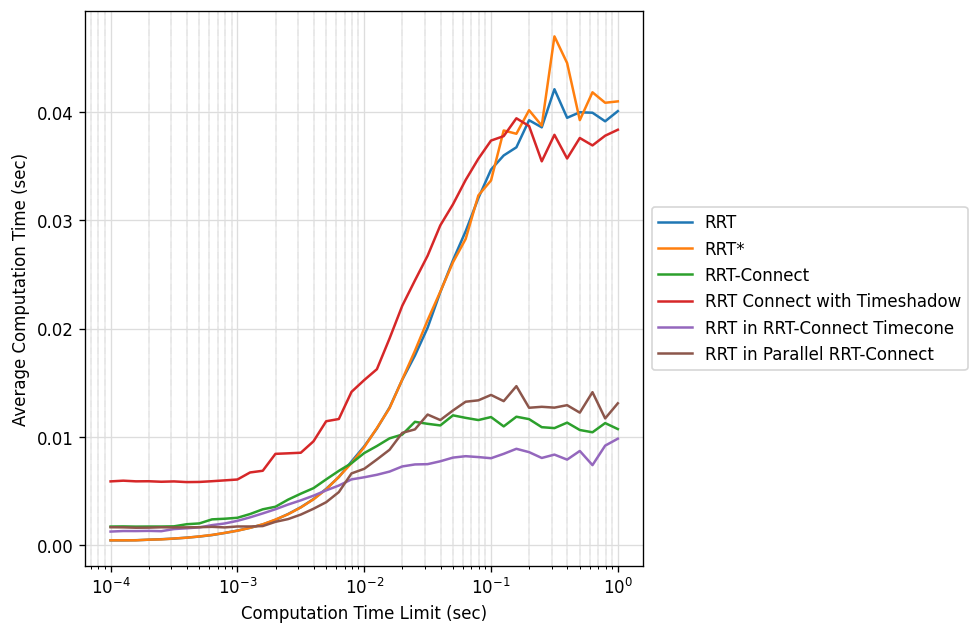

In [70]:
fig = plt.figure(figsize=(6,6), dpi=1920/16)
ax = plt.subplot(1,1,1)
plotLog = False

compTimeRRT_List = []
compTimeRRTstar_List = []
compTimeRRTC_List = []
compTimeRRTCTS_List = []
compTimeRRTTC_List = []
compTimeRRTCP_List = []
for i in range(len(computationTimeLimit_List)):
    compTimeRRT_List.append(compTime[str(i)][0])
    compTimeRRTstar_List.append(compTime[str(i)][1])
    compTimeRRTC_List.append(compTime[str(i)][2])
    compTimeRRTCTS_List.append(compTime[str(i)][3])
    compTimeRRTTC_List.append(compTime[str(i)][4])
    compTimeRRTCP_List.append(compTime[str(i)][5])

if plotLog:
    plt.plot(computationTimeLimit_List, compTimeRRT_List, label='RRT')
    plt.plot(computationTimeLimit_List, compTimeRRTstar_List, label='RRT*')
    plt.plot(computationTimeLimit_List, compTimeRRTC_List, label='RRT-Connect')
    plt.plot(computationTimeLimit_List, compTimeRRTCTS_List, label='RRT Connect with Timeshadow')
    plt.plot(computationTimeLimit_List, compTimeRRTTC_List, label='RRT in RRT-Connect Timecone')
    plt.plot(computationTimeLimit_List, compTimeRRTCP_List, label='RRT in Parallel RRT-Connect')
    # ax.set_xscale('log')
    plt.xlabel('log(Computation Time Limit) (log(sec))')
else:
    plt.plot(10**computationTimeLimit_List, compTimeRRT_List, label='RRT')
    plt.plot(10**computationTimeLimit_List, compTimeRRTstar_List, label='RRT*')
    plt.plot(10**computationTimeLimit_List, compTimeRRTC_List, label='RRT-Connect')
    plt.plot(10**computationTimeLimit_List, compTimeRRTCTS_List, label='RRT Connect with Timeshadow')
    plt.plot(10**computationTimeLimit_List, compTimeRRTTC_List, label='RRT in RRT-Connect Timecone')
    plt.plot(10**computationTimeLimit_List, compTimeRRTCP_List, label='RRT in Parallel RRT-Connect')
    ax.set_xscale('log')
    plt.xlabel('Computation Time Limit (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='k', linestyle=':', linewidth=0.25)
plt.ylabel('Average Computation Time (sec)')

Text(0, 0.5, 'Success Rate')

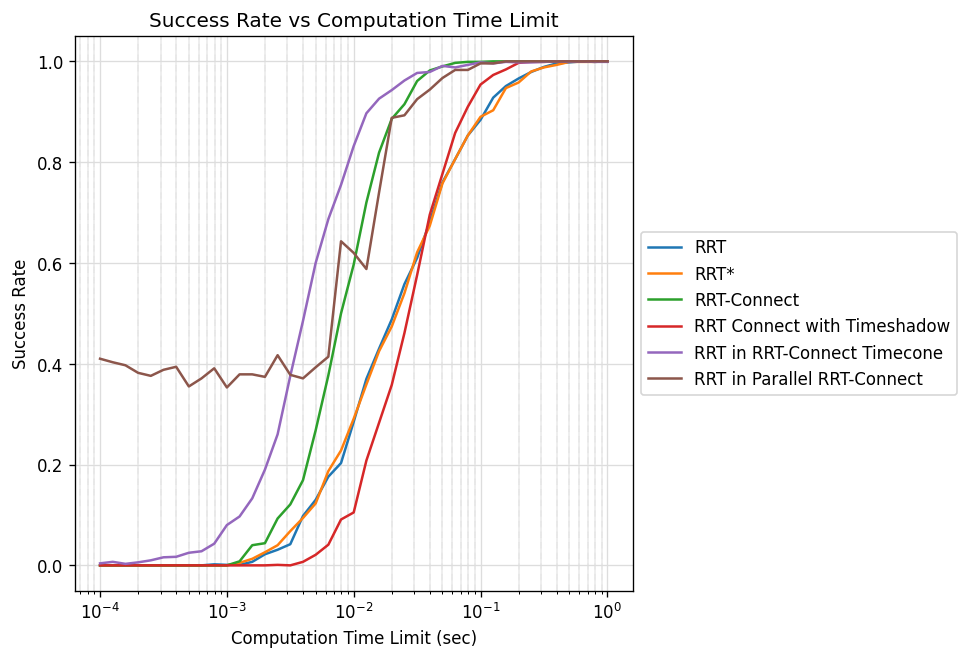

In [71]:
fig = plt.figure(figsize=(6,6), dpi=1920/16)
ax = plt.subplot(1,1,1)
plotLog = False

successRateRRT_List = []
successRateRRTstar_List = []
successRateRRTC_List = []
successRateRRTCTS_List = []
successRateRRTTC_List = []
successRateRRTCP_List = []
for i in range(len(computationTimeLimit_List)):
    successRateRRT_List.append(successRate[str(i)][0])
    successRateRRTstar_List.append(successRate[str(i)][1])
    successRateRRTC_List.append(successRate[str(i)][2])
    successRateRRTCTS_List.append(successRate[str(i)][3])
    successRateRRTTC_List.append(successRate[str(i)][4])
    successRateRRTCP_List.append(successRate[str(i)][5])

if plotLog:
    plt.plot(computationTimeLimit_List, successRateRRT_List, label='RRT')
    plt.plot(computationTimeLimit_List, successRateRRTstar_List, label='RRT*')
    plt.plot(computationTimeLimit_List, successRateRRTC_List, label='RRT-Connect')
    plt.plot(computationTimeLimit_List, successRateRRTCTS_List, label='RRT Connect with Timeshadow')
    plt.plot(computationTimeLimit_List, successRateRRTTC_List, label='RRT in RRT-Connect Timecone')
    plt.plot(computationTimeLimit_List, successRateRRTCP_List, label='RRT in Parallel RRT-Connect')
    plt.xlabel('log(Computation Time Limit) (log(sec))')
else:
    plt.plot(10**computationTimeLimit_List, successRateRRT_List, label='RRT')
    plt.plot(10**computationTimeLimit_List, successRateRRTstar_List, label='RRT*')
    plt.plot(10**computationTimeLimit_List, successRateRRTC_List, label='RRT-Connect')
    plt.plot(10**computationTimeLimit_List, successRateRRTCTS_List, label='RRT Connect with Timeshadow')
    plt.plot(10**computationTimeLimit_List, successRateRRTTC_List, label='RRT in RRT-Connect Timecone')
    plt.plot(10**computationTimeLimit_List, successRateRRTCP_List, label='RRT in Parallel RRT-Connect')
    ax.set_xscale('log')
    plt.xlabel('Computation Time Limit (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='k', linestyle=':', linewidth=0.25)
plt.title('Success Rate vs Computation Time Limit')
plt.ylabel('Success Rate')

Text(0, 0.5, 'Average Path Distance (unit)')

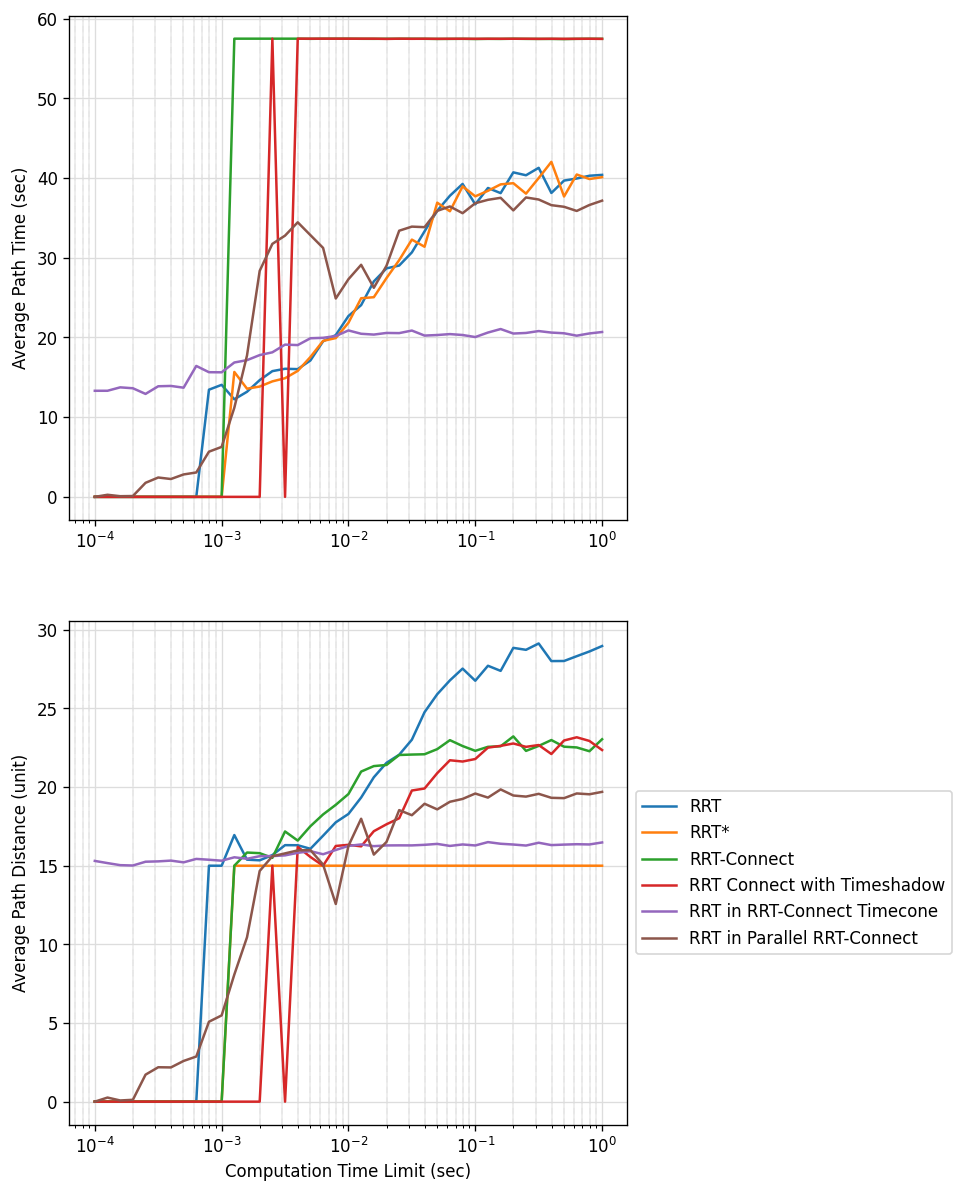

In [72]:
fig = plt.figure(figsize=(6,12), dpi=1920/16)
plotLog = False
ax = plt.subplot(2, 1, 1)
pathTimeRRT_List = []
pathTimeRRTstar_List = []
pathTimeRRTC_List = []
pathTimeRRTCTS_List = []
pathTimeRRTTC_List = []
pathTimeRRTCP_List = []
for i in range(len(computationTimeLimit_List)):
    pathTimeRRT_List.append(np.abs(pathTime[str(i)][0]))
    pathTimeRRTstar_List.append(np.abs(pathTime[str(i)][1]))
    pathTimeRRTC_List.append(np.abs(pathTime[str(i)][2]))
    pathTimeRRTCTS_List.append(np.abs(pathTime[str(i)][3]))
    pathTimeRRTTC_List.append(np.abs(pathTime[str(i)][4]))
    pathTimeRRTCP_List.append(np.abs(pathTime[str(i)][5]))

if plotLog:
    plt.plot(computationTimeLimit_List, pathTimeRRT_List, label='RRT')
    plt.plot(computationTimeLimit_List, pathTimeRRTstar_List, label='RRT*')
    plt.plot(computationTimeLimit_List, pathTimeRRTC_List, label='RRT-Connect')
    plt.plot(computationTimeLimit_List, pathTimeRRTCTS_List, label='RRT Connect with Timeshadow')
    plt.plot(computationTimeLimit_List, pathTimeRRTTC_List, label='RRT in RRT-Connect Timecone')
    plt.plot(computationTimeLimit_List, pathTimeRRTCP_List, label='RRT in Parallel RRT-Connect')
    # plt.xlabel('log(Computation Lime Limit) (log(sec))')
else:
    plt.plot(10**computationTimeLimit_List, pathTimeRRT_List, label='RRT')
    plt.plot(10**computationTimeLimit_List, pathTimeRRTstar_List, label='RRT*')
    plt.plot(10**computationTimeLimit_List, pathTimeRRTC_List, label='RRT-Connect')
    plt.plot(10**computationTimeLimit_List, pathTimeRRTCTS_List, label='RRT Connect with Timeshadow')
    plt.plot(10**computationTimeLimit_List, pathTimeRRTTC_List, label='RRT in RRT-Connect Timecone')
    plt.plot(10**computationTimeLimit_List, pathTimeRRTCP_List, label='RRT in Parallel RRT-Connect')
    # plt.xlabel('Computation Lime Limit (sec)')
    ax.set_xscale('log')
plt.ylabel('Average Path Time (sec)')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='k', linestyle=':', linewidth=0.25)

ax = plt.subplot(2, 1, 2)
pathDistRRT_List = []
pathDistRRTstar_List = []
pathDistRRTC_List = []
pathDistRRTCTS_List = []
pathDistRRTTC_List = []
pathDistRRTCP_List = []
for i in range(len(computationTimeLimit_List)):
    pathDistRRT_List.append(np.abs(pathDist[str(i)][0]))
    pathDistRRTstar_List.append(np.abs(pathDist[str(i)][1]))
    pathDistRRTC_List.append(np.abs(pathDist[str(i)][2]))
    pathDistRRTCTS_List.append(np.abs(pathDist[str(i)][3]))
    pathDistRRTTC_List.append(np.abs(pathDist[str(i)][4]))
    pathDistRRTCP_List.append(np.abs(pathDist[str(i)][5]))

if plotLog:
    plt.plot(computationTimeLimit_List, pathDistRRT_List, label='RRT')
    plt.plot(computationTimeLimit_List, pathDistRRTstar_List, label='RRT*')
    plt.plot(computationTimeLimit_List, pathDistRRTC_List, label='RRT-Connect')
    plt.plot(computationTimeLimit_List, pathDistRRTCTS_List, label='RRT Connect with Timeshadow')
    plt.plot(computationTimeLimit_List, pathDistRRTTC_List, label='RRT in RRT-Connect Timecone')
    plt.plot(computationTimeLimit_List, pathDistRRTCP_List, label='RRT in Parallel RRT-Connect')
    plt.xlabel('log(Computation Time Limit) (log(sec))')
else:
    plt.plot(10**computationTimeLimit_List, pathDistRRT_List, label='RRT')
    plt.plot(10**computationTimeLimit_List, pathDistRRTstar_List, label='RRT*')
    plt.plot(10**computationTimeLimit_List, pathDistRRTC_List, label='RRT-Connect')
    plt.plot(10**computationTimeLimit_List, pathDistRRTCTS_List, label='RRT Connect with Timeshadow')
    plt.plot(10**computationTimeLimit_List, pathDistRRTTC_List, label='RRT in RRT-Connect Timecone')
    plt.plot(10**computationTimeLimit_List, pathDistRRTCP_List, label='RRT in Parallel RRT-Connect')
    ax.set_xscale('log')
    plt.xlabel('Computation Time Limit (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='k', linestyle=':', linewidth=0.25)
plt.ylabel('Average Path Distance (unit)')

In [ ]:
asdfasfasf

In [54]:
V_RRTTC_dict = vertex['RRTTC']
E_RRTTC_dict = edge['RRTTC']
P_RRTTC_dict = path['RRTTC']

print(len(V_RRTTC_dict))
print(len(P_RRTTC_dict))

1000
1000


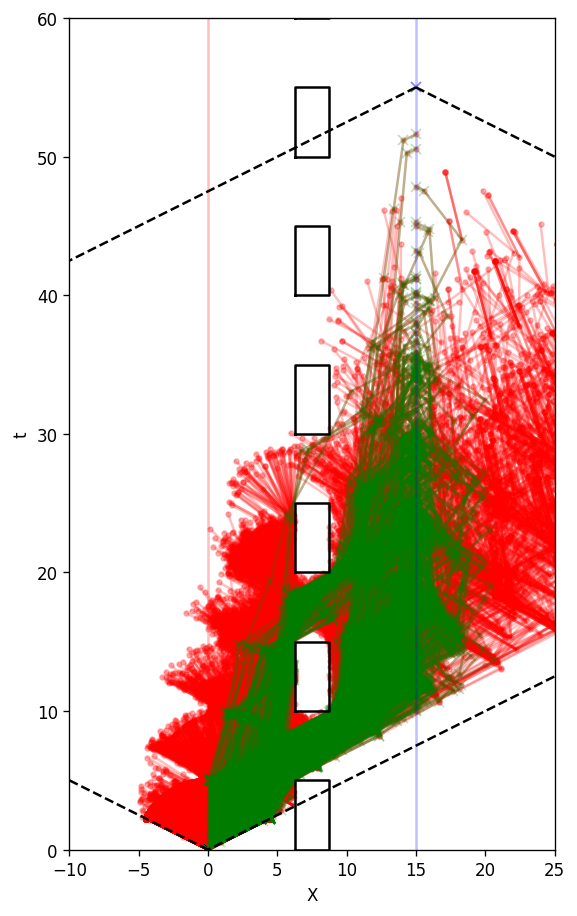

In [66]:
fig = plt.figure(figsize=(9, 9), dpi=1920/16)
ax = fig.subplots()
tf = 55
alpha_val = 0.25
# RRTConnect
for i in range(len(V_RRTTC_dict)):
    for rrtv in V_RRTTC_dict[str(i)]:
        plt.plot(rrtv[0], rrtv[1], 'r.', alpha=alpha_val)
    for rrte in E_RRTTC_dict[str(i)]:
        plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=alpha_val)
for i in range(len(P_RRTTC_dict)):
    if P_RRTTC_dict[str(i)] is not None:
        for pathi in P_RRTTC_dict[str(i)]:
            plt.plot(pathi[0], pathi[1], 'gx', alpha=alpha_val)
        for ii in range(len(P_RRTTC_dict[str(i)])-1):
            plt.plot([P_RRTTC_dict[str(i)][ii][0], P_RRTTC_dict[str(i)][ii+1][0]], [P_RRTTC_dict[str(i)][ii][1], P_RRTTC_dict[str(i)][ii+1][1]], '-g', alpha=alpha_val)


num_obs = 1
x0 = 0
xf = 15
xobs = [[6.25, 10-1.25]]
obs_vec = [[0, 5, 5]]

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
plt.xlim(x0-10, xf+10)
plt.ylim(0, tf+5)
plt.xlabel('X')
plt.ylabel('t')
plt.savefig('RRT_in_Timecone_OverlapImage.png')

In [ ]:
print("------------------------------------------------------------------------------------------------------------")
print("                    |           RRT             |           RRT*             |               RRT-Connect           |               RRT-ConnectTS           |               RRT-Timecone")
print("Success Rate        : {},                         {},                          {},                          {},                          {}".format(successRateRRT/iter_max, successRateRRTstar/iter_max, successRateRRTC/iter_max, successRateRRTCTS/iter_max, successRateRRTTC/iter_max))
print("Mean Comp Time (sec): {},           {},            {},            {},            {}".format(sum(compTimeRRT)/len(compTimeRRT), sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCTS)/len(compTimeRRTCTS), sum(compTimeRRTTC)/len(compTimeRRTTC)))
print("Mean Path Time (sec): {},           {},            {},            {},            {}".format(sum(pathTimeRRT)/len(pathTimeRRT), sum(pathTimeRRTstar)/len(pathTimeRRTstar), sum(pathTimeRRTC)/len(pathTimeRRTC), sum(pathTimeRRTCTS)/len(pathTimeRRTCTS), sum(pathTimeRRTTC)/len(pathTimeRRTTC)))
print("Mean Path Dist (sec): {},           {},            {},            {},            {}".format(sum(pathDistRRT)/len(pathDistRRT), sum(pathDistRRTstar)/len(pathDistRRTstar), sum(pathDistRRTC)/len(pathDistRRTC), sum(pathDistRRTCTS)/len(pathDistRRTCTS), sum(pathDistRRTTC)/len(pathDistRRTTC)))


------------------------------------------------------------------------------------------------------------
                    |           RRT             |           RRT*             |               RRT-Connect           |               RRT-ConnectTS           |               RRT-Timecone
Success Rate        : 1.0,                         1.0,                          1.0,                          1.0,                          1.0
Mean Comp Time (sec): 0.040508456707000734,           0.041641772985458375,            0.01100625991821289,            0.04087807464599609,            0.008191756248474121
Mean Path Time (sec): -40.32289196210732,           39.86327338620115,            57.485000777483016,            57.490000519762596,            -20.19435955554058
Mean Path Dist (sec): 28.78784084264132,           15.0,            22.54491185992585,            22.06690801703415,            16.256371876719967


Test MonteCarlo for RRT-Connect Parallel sampling

In [47]:
monte_carlo_K = 1000
k = 0
compTimeRRTCP = []
successRateRRTCP = 0
pathTimeRRTCP = []
pathDistRRTCP = []
while k < monte_carlo_K:
    print('k: ', k)
    # Position
    x0 = 0
    xf = 30
    xobs = [[5, 7], [10, 11], [15, 16], [23, 25]]
    prox = [2.5, 2.5] # [x, t]

    # General RRT Settings
    vmax = 2
    max_time = 5

    # Obstacle Setting
    # [start, close, open]
    obs1 = [0, 2.5, 2.5]
    obs2 = [0, 4, 4]
    obs3 = [0, 3, 3]
    obs4 = [0, 8, 2.5]
    obs_vec = [obs1, obs2, obs3, obs4]
    
    pathFound, time_RRTCP, total_path_distance, total_path_time, success_RRTCP, final_path_parallel, V_RRTCPa, V_RRTCPb, E_RRTCPa, E_RRTCPb = RRTC_Parallel(1)
    
    compTimeRRTstar.append(time_RRTCP)
    if pathFound:
        pathTimeRRTCP.append(total_path_time)
        pathDistRRTCP.append(total_path_distance)
    successRateRRTCP += success_RRTCP
    k += 1

k:  0
Path Found
47.36985083178463
k:  1
Path Found
35.37905226594151
k:  2
Path Found
28.5909462594362
k:  3
Path Found
42.10693298935123
k:  4
k:  5
k:  6
Path Found
40.52609608092332
k:  7
Path Found
24.505808298956453
k:  8
k:  9
Path Found
33.92307594172582
k:  10
Path Found
26.501492626814922
k:  11
k:  12
Path Found
38.0342503508109
k:  13
Path Found
37.29109491663508
k:  14
k:  15
Path Found
38.426169787857674
k:  16
k:  17
Path Found
40.639341886952884
k:  18
Path Found
23.528181411691918
k:  19
Path Found
27.405280856454777
k:  20
Path Found
40.49020756471744
k:  21
Path Found
32.5007289498856
k:  22
Path Found
46.91076379355273
k:  23
Path Found
41.49857634903337
k:  24
Path Found
29.002517541877975
k:  25
k:  26
Path Found
53.005710527813875
k:  27
Path Found
23.044254744569272
k:  28
k:  29
Path Found
24.631108902738355
k:  30
Path Found
30.387856948815948
k:  31
k:  32
Path Found
54.31023024858621
k:  33
Path Found
27.84020144746843
k:  34
Path Found
32.58821419673752
k: 